In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, minimize
from scipy.misc import derivative


/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Simulating a dataset with diminishing returns: Ad Spend & Revenue
np.random.seed(42)
ad_spend = np.linspace(100, 10000, 50)
revenue = 5000 * (1 - np.exp(-0.0005 * ad_spend)) + np.random.normal(0, 150, 50) 

df = pd.DataFrame({'ad_spend': ad_spend, 'revenue': revenue})

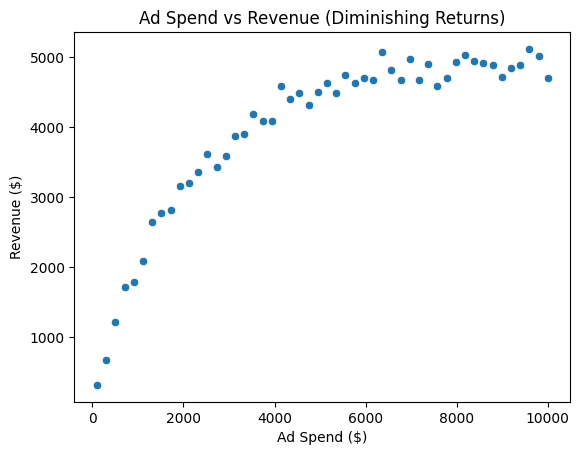

In [3]:
# Visualizing the Relationship
sns.scatterplot(x=df["ad_spend"], y=df["revenue"])
plt.xlabel("Ad Spend ($)")
plt.ylabel("Revenue ($)")
plt.title("Ad Spend vs Revenue (Diminishing Returns)")
plt.show()

## Measuring diminishing returns

One of the important features of advertising is diminishing returns, which means that beyond a certain point, increasing ad spend does not bring the same increase in revenue - marginal returns start decreasing. This relationship can be captured using non-linear models, such as:

* Quadratic Regression – Captures concave relationships.
* Logarithmic Transformation – Models diminishing marginal effects.
* Hill Function (S-Curve Model) – Captures saturation effects more realistically.

### Quadratic Model
- ✅ Can model an initial increase followed by a decline. 

At low spend → Revenue increases. At medium spend → Growth slows. At very high spend → Revenue declines.

Formula: Revenue = a * Spend^2 + b * Spend + c 

Where:

- a = quadratic term (controls curvature)
- b = linear term (controls overall growth)
- c = intercept (base revenue)

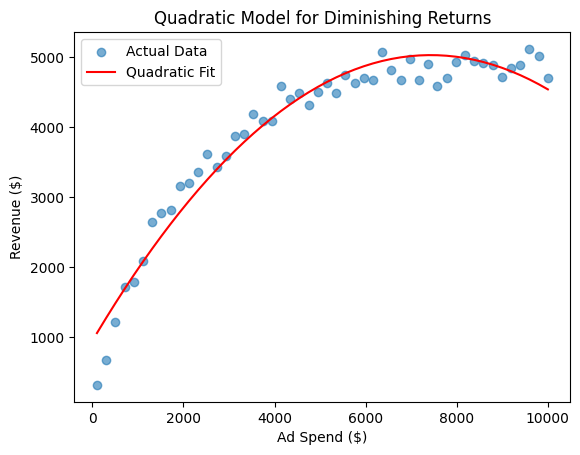

In [4]:
# Adding a quadratic feature
df["ad_spend_squared"] = df["ad_spend"] ** 2

# Fitting a quadratic Regression Model
X = df[["ad_spend", "ad_spend_squared"]]
y = df["revenue"]

quad_model = LinearRegression().fit(X, y)

# Predict and plot
df["predicted_revenue"] = quad_model.predict(X)

plt.scatter(df["ad_spend"], df["revenue"], label="Actual Data", alpha=0.6)
plt.plot(df["ad_spend"], df["predicted_revenue"], color="red", label="Quadratic Fit")
plt.xlabel("Ad Spend ($)")
plt.ylabel("Revenue ($)")
plt.title("Quadratic Model for Diminishing Returns")
plt.legend()
plt.show()


### Logarithmic Model
- ✅ Captures diminishing returns: Revenue increases quickly at first, then slows.
- ✅ No plateau: Revenue keeps increasing, but very slowly at high spend.
- ✅ Best for small spend optimization: If we don’t expect a hard cap on revenue, log models work well.

At low spend → Revenue grows quickly. At high spend → Growth slows, but never completely stops.

Formula: Revenue = a * log (b + Spend)

Where:
- a = scaling factor (how high revenue can go)
- b = shift factor (to prevent log(0) issues)

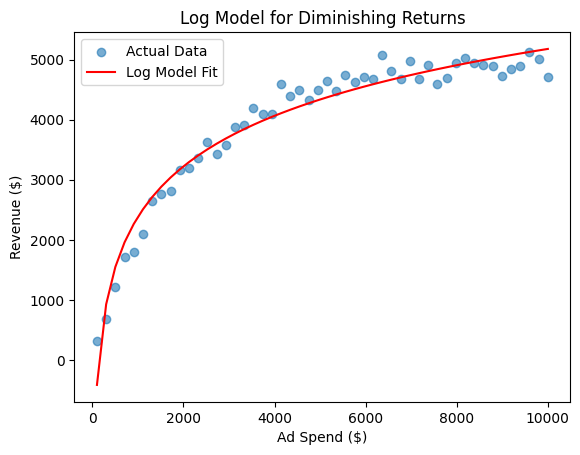

In [5]:
# Adding a logarithmic feature
df["log_ad_spend"] = np.log(df["ad_spend"])

#Fitting a Regression model with logarithmic feature
log_model = LinearRegression().fit(df[["log_ad_spend"]], y)

# Predicting and plotting the result
df["predicted_revenue_log"] = log_model.predict(df[["log_ad_spend"]])

plt.scatter(df["ad_spend"], df["revenue"], label="Actual Data", alpha=0.6)
plt.plot(df["ad_spend"], df["predicted_revenue_log"], color="red", label="Log Model Fit")
plt.xlabel("Ad Spend ($)")
plt.ylabel("Revenue ($)")
plt.title("Log Model for Diminishing Returns")
plt.legend()
plt.show()

### Hill Function
- ✅ Captures saturation: Revenue grows quickly at first but then plateaus.
- ✅ Asymptotic behavior: Even if we increase spend infinitely, revenue does not grow indefinitely—it levels off.
- ✅ Best for real-world ad spend modeling: Most marketing channels hit a saturation point beyond which additional spend has little impact.

At low spend → Revenue increases rapidly. At medium spend → Growth slows. At high spend → Revenue plateaus.

Formula: Revenue = a * Spend^b / c + Spend^b

Where:
- a = maximum potential revenue (upper bound)
- b = steepness of growth (how quickly revenue increases initially)
- c = half-saturation point (the spend level where revenue reaches half of a)

In [6]:
# Defining the Hill Function
def hill_function(x, a, b, c):
    return (a * x**b) / (c + x**b)

# Providing initial parameter guesses
initial_guesses = [max(df["revenue"]), 1, np.median(df["ad_spend"])]  

# Fitting the Model with Initial Guesses
params, covariance = curve_fit(hill_function, df["ad_spend"], df["revenue"], 
                               p0=initial_guesses, maxfev=10000)
a, b, c = params
print("Fitted Parameters:")
print(f"Maximum potential revenue (a): {params[0]}")
print(f"Steepness of growth (b): {params[1]}")
print(f"Half-saturation point (c): {params[2]}")

Fitted Parameters:
Maximum potential revenue (a): 5529.73377196969
Steepness of growth (b): 1.2166917550184853
Half-saturation point (c): 7552.368852264828


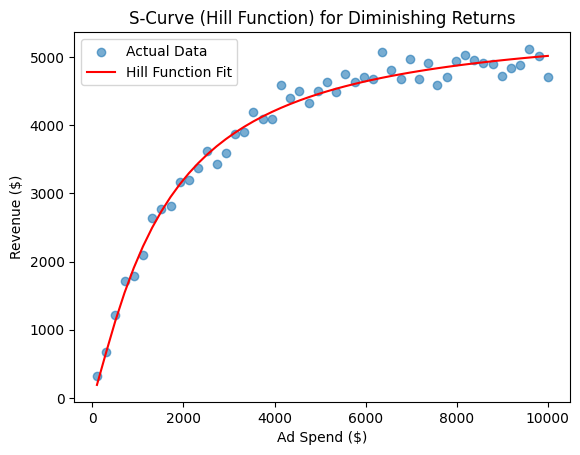

In [7]:
df["predicted_revenue_hill"] = hill_function(df["ad_spend"], *params)

plt.scatter(df["ad_spend"], df["revenue"], label="Actual Data", alpha=0.6)
plt.plot(df["ad_spend"], df["predicted_revenue_hill"], color="red", label="Hill Function Fit")
plt.xlabel("Ad Spend ($)")
plt.ylabel("Revenue ($)")
plt.legend()
plt.title("S-Curve (Hill Function) for Diminishing Returns")
plt.show()

### Finding the optimal spend

When trying to find optimal spend, first we need to define what does *'optimal'* mean. 
One way of defining it could be ***based on efficiency***: at which level of spend ***Marginal Cost (MC) = Marginal Revenue (MR)***?

Marginal cost is the additional costs incurred when producing one more unit of a good or service. You can find it out by asking your finance team or looking at historical cost per conversion data.

* At MC < MR we are underspending and can achieve higher marginal return by increasing our spend.
* AT MC > MR we overspending. The revenue is still increasing as we increase spend, but at a lower rate than spend (additional dollar of spend brings in less than a dollar of additional revenue).

For the purpose of demonstration I'll assume that Marginal cost is $1.5.


In [8]:
# Defining the function for Marginal Revenue
def marginal_revenue_numerical(x):
    return derivative(lambda x: hill_function(x, *params), x, dx=1e-5, n=1)

# Computing marginal revenues over spend range
spend_range = np.linspace(min(ad_spend), max(ad_spend), 1000)
mr_values = np.array([marginal_revenue_numerical(x) for x in spend_range])

# Computing at which point MC crosses MR
MC = 1.5
mr_signs = np.sign(mr_values - MC)
crossing_index = np.where(np.diff(mr_signs) != 0)[0]

if len(crossing_index) > 0:
    bracket_min = spend_range[crossing_index[0]]
    bracket_max = spend_range[crossing_index[0] + 1]
    optimal_spend_result = root_scalar(lambda x: marginal_revenue_numerical(x) - MC, 
                                       bracket=[bracket_min, bracket_max], method='brentq')

    optimal_spend = optimal_spend_result.root if optimal_spend_result.converged else None

/var/folders/5y/xktw_n857vb915jnv6mlqv6c0000gn/T/ipykernel_5586/2898936476.py:3: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: hill_function(x, *params), x, dx=1e-5, n=1)


NameError: name 'root_scalar' is not defined

NameError: name 'optimal_spend' is not defined

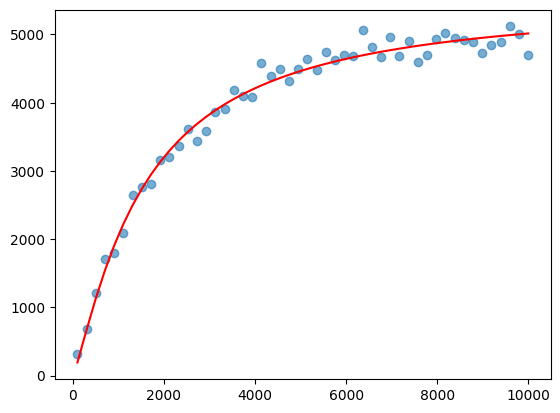

In [9]:
# Plotting optimal spend by efficiency on the graph

plt.scatter(df["ad_spend"], df["revenue"], label="Actual Data", alpha=0.6)
plt.plot(df["ad_spend"], df["predicted_revenue_hill"], color="red", label="Hill Function Fit")

if optimal_spend:
    plt.axvline(optimal_spend, color='red', linestyle='--', label="Optimal Spend (MR = MC)")
    plt.scatter(optimal_spend, hill_function(optimal_spend, *params), color='red', s=100)

plt.xlabel("Ad Spend ($)")
plt.ylabel("Revenue ($)")
plt.title("Optimal spend based on efficiency")
plt.legend()
plt.show()

print(f"Optimal Spend (MC = MR): {optimal_spend if optimal_spend else 'Not Found'}")

Another way of defining optimal spend could be ***based on profit***: at which level of spend the profit is at its maximum?

In [10]:
# Defining profit function to maximize
def profit_function(x):
    revenue = hill_function(x, *params)
    return -(revenue - x)  # Negative sign because we use a minimizer

# Finding optimal spend
optimal_result = minimize(profit_function, x0=5000, bounds=[(0, 10000)], method="L-BFGS-B")

optimal_spend = optimal_result.x[0]
optimal_revenue = hill_function(optimal_spend, *params)

print(f"Optimal Ad Spend: ${optimal_spend:.2f}")
print(f"Expected Revenue at Optimal Spend: ${optimal_revenue:.2f}")
print(f"Expected Profit: ${optimal_revenue - optimal_spend:.2f}")


Optimal Ad Spend: $1677.42
Expected Revenue at Optimal Spend: $2908.97
Expected Profit: $1231.55


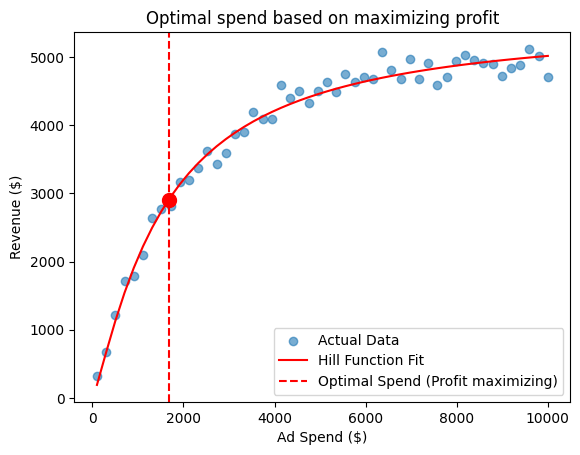

Optimal Spend (Profit maximizing): 1677.41703612877


In [11]:
# Plotting optimal spend by profit on the graph

plt.scatter(df["ad_spend"], df["revenue"], label="Actual Data", alpha=0.6)
plt.plot(df["ad_spend"], df["predicted_revenue_hill"], color="red", label="Hill Function Fit")

if optimal_spend:
    plt.axvline(optimal_spend, color='red', linestyle='--', label="Optimal Spend (Profit maximizing)")
    plt.scatter(optimal_spend, hill_function(optimal_spend, *params), color='red', s=100)

plt.xlabel("Ad Spend ($)")
plt.ylabel("Revenue ($)")
plt.title("Optimal spend based on maximizing profit")
plt.legend()
plt.show()

print(f"Optimal Spend (Profit maximizing): {optimal_spend if optimal_spend else 'Not Found'}")